In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.head(1)

,ID,Type_of_AC,Model,Cooling_Capacity,Avg_Temp,Room_SIze,Num_People,Star_Rating,Age_of_Unit,Maintenance,Avg_Usage,Avg_AC_Temp,City,Input_Power,Electricity_Consumption_AC
0,795823,Split,1.5,6579.15,43,1873.5,3,3,5.0,0,1.72,31.333333,Cairo,2863.295221,1.924


In [3]:
print("shape of train data :", data.shape,'\n')
print('shape of test data :',test.shape)

shape of train data : (15000, 15) 

shape of test data : (5000, 14)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          15000 non-null  int64  
 1   Type_of_AC                  15000 non-null  object 
 2   Model                       14130 non-null  float64
 3   Cooling_Capacity            15000 non-null  float64
 4   Avg_Temp                    15000 non-null  int64  
 5   Room_SIze                   13987 non-null  object 
 6   Num_People                  15000 non-null  int64  
 7   Star_Rating                 14103 non-null  object 
 8   Age_of_Unit                 14018 non-null  float64
 9   Maintenance                 15000 non-null  int64  
 10  Avg_Usage                   15000 non-null  float64
 11  Avg_AC_Temp                 15000 non-null  float64
 12  City                        13480 non-null  object 
 13  Input_Power                 142

For the following features in the dataset, we need to change their data types to better align with the intended data representation:

-  `Input_Power`: The current data type is 'object', but it should be converted to 'float' for more precise numerical representation.

-  `Room_SIze`: The current data type is 'object', and it should be changed to 'float' to accurately represent the room size as a decimal number.

-  `Star_Rating`: Although the current data type is 'object', it should be transformed into an 'int' type to reflect the star rating as a whole number.

-  `Age_of_Unit`: The current data type is 'object', but it should be converted to 'int' to represent the age of the unit as a whole number.

By observing the data , some of the unwanted characters were present into the multiple columns which leading to change the datatype of that column to object, in further analysis we will solve this issue.

#### Unwanted characters : $$ , .,blank,?,??,_...etc

In [5]:
data_cheking = data.drop(['Type_of_AC','City'],axis=1)

In [6]:
#Checking for the unwanted characters from each column
def is_float_or_int(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Dictionary to store columns with unwanted characters and their counts
columns_with_unwanted_chars = {}

for column in data_cheking.columns:
    # Initialize the count for this column
    count = 0
    
    # Check each value in the column for unwanted characters
    for value in data_cheking[column]:
        if not is_float_or_int(str(value)):
            # If a non-numeric value is found, increment the count
            count += 1
    
    # If there are values with unwanted characters, store the column name and count
    if count > 0:
        columns_with_unwanted_chars[column] = count
    
# Print the columns with unwanted characters
print("Columns with unwanted characters:", columns_with_unwanted_chars)

Columns with unwanted characters: {'Room_SIze': 16, 'Star_Rating': 21, 'Input_Power': 11}


In [7]:
###Replacing unwanted characters as null values
# List of columns to check and replace unwanted characters
columns_to_check = ['Room_SIze', 'Star_Rating', 'Input_Power']

# Iterate through the specified columns
for column in columns_to_check:
    for index, value in enumerate(data[column]):
        if not is_float_or_int(str(value)):
            # If a non-numeric value is found, replace it with NaN
            data.at[index, column] = np.nan

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          15000 non-null  int64  
 1   Type_of_AC                  15000 non-null  object 
 2   Model                       14130 non-null  float64
 3   Cooling_Capacity            15000 non-null  float64
 4   Avg_Temp                    15000 non-null  int64  
 5   Room_SIze                   13971 non-null  object 
 6   Num_People                  15000 non-null  int64  
 7   Star_Rating                 14082 non-null  object 
 8   Age_of_Unit                 14018 non-null  float64
 9   Maintenance                 15000 non-null  int64  
 10  Avg_Usage                   15000 non-null  float64
 11  Avg_AC_Temp                 15000 non-null  float64
 12  City                        13480 non-null  object 
 13  Input_Power                 142

In [9]:
#Change the datatype of ['Room_SIze', 'Star_Rating', 'Input_Power'] from object to int , (we removed all unwanted characters)
data['Room_SIze'] = data['Room_SIze'].astype(float)
data['Input_Power'] = data['Input_Power'].astype(float)
data['Star_Rating'] = data['Star_Rating'].astype(float)

In [10]:
#Checking for the Missing Values
data.isnull().sum()

ID                               0
Type_of_AC                       0
Model                          870
Cooling_Capacity                 0
Avg_Temp                         0
Room_SIze                     1029
Num_People                       0
Star_Rating                    918
Age_of_Unit                    982
Maintenance                      0
Avg_Usage                        0
Avg_AC_Temp                      0
City                          1520
Input_Power                    724
Electricity_Consumption_AC       0
dtype: int64

In [11]:
#Checking for the Missing Values percentage for each feature
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage = missing_percentage.round(2)  # Round to two decimal places
print(missing_percentage)

ID                             0.00
Type_of_AC                     0.00
Model                          5.80
Cooling_Capacity               0.00
Avg_Temp                       0.00
Room_SIze                      6.86
Num_People                     0.00
Star_Rating                    6.12
Age_of_Unit                    6.55
Maintenance                    0.00
Avg_Usage                      0.00
Avg_AC_Temp                    0.00
City                          10.13
Input_Power                    4.83
Electricity_Consumption_AC     0.00
dtype: float64


### Exploring Missing Value features

#### 1.Model (Categorical Data - Bar Chart):

missing value % of Model is : 5.80


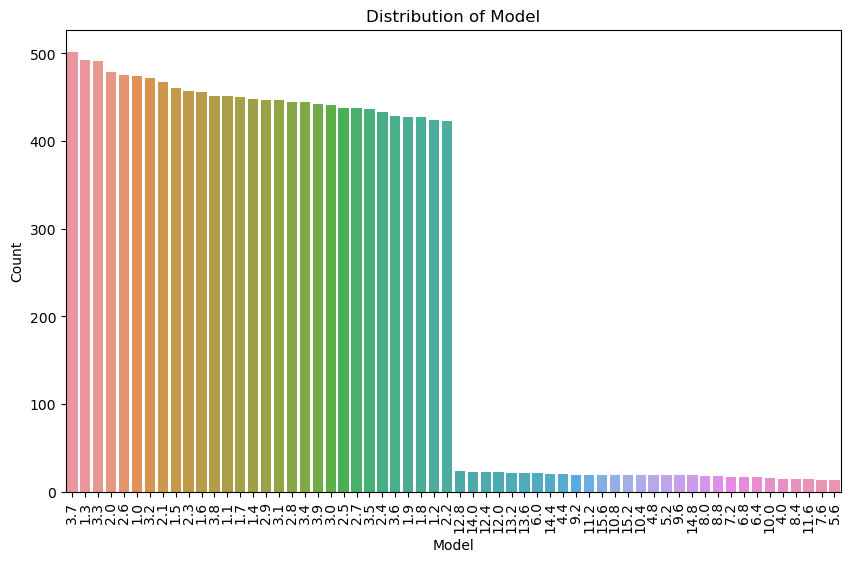

In [12]:
plt.figure(figsize=(10, 6))
model_counts = data['Model'].value_counts().sort_values(ascending=False)
sns.barplot(x=model_counts.index, y=model_counts.values, order=model_counts.index)
plt.xticks(rotation=90)
plt.title('Distribution of Model')
plt.xlabel('Model')
plt.ylabel('Count')

#Missing value %
print("missing value % of Model is : 5.80")
plt.show()

#### 2.Star_Rating (Categorical Data - Bar Chart in Descending Order):

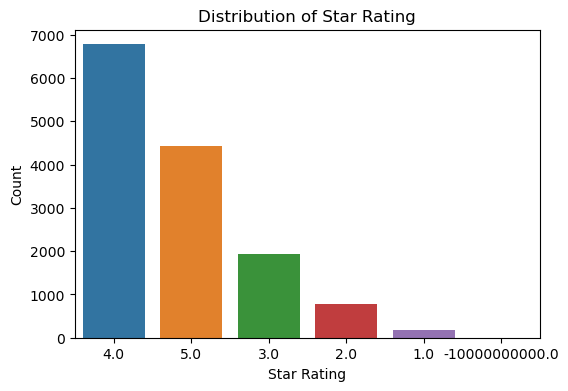

In [13]:
plt.figure(figsize=(6, 4))
star_rating_counts = data['Star_Rating'].value_counts().sort_values(ascending=False)
sns.barplot(x=star_rating_counts.index, y=star_rating_counts.values, order=star_rating_counts.index)
plt.title('Distribution of Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

#### 4.City (Categorical Data - Bar Chart in Descending Order):

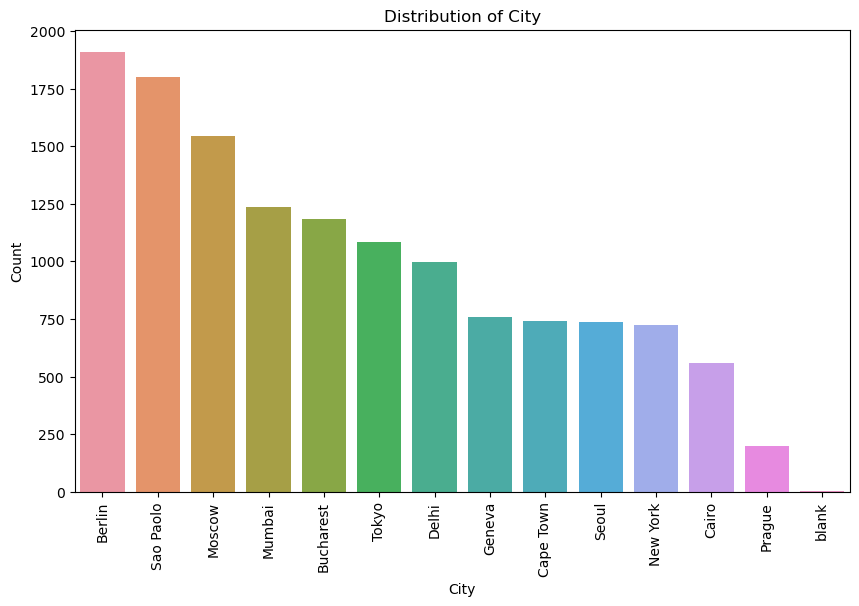

In [14]:
plt.figure(figsize=(10, 6))
city_counts = data['City'].value_counts().sort_values(ascending=False)
sns.barplot(x=city_counts.index, y=city_counts.values, order=city_counts.index)
plt.xticks(rotation=90)
plt.title('Distribution of City')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          15000 non-null  int64  
 1   Type_of_AC                  15000 non-null  object 
 2   Model                       14130 non-null  float64
 3   Cooling_Capacity            15000 non-null  float64
 4   Avg_Temp                    15000 non-null  int64  
 5   Room_SIze                   13971 non-null  float64
 6   Num_People                  15000 non-null  int64  
 7   Star_Rating                 14082 non-null  float64
 8   Age_of_Unit                 14018 non-null  float64
 9   Maintenance                 15000 non-null  int64  
 10  Avg_Usage                   15000 non-null  float64
 11  Avg_AC_Temp                 15000 non-null  float64
 12  City                        13480 non-null  object 
 13  Input_Power                 142

### Imputation of Missing Values

- Note : We tried to drop the Missing values which leads to loss of data around 33.33%, which is not a good approach. 
So we are imputing missing values with central tendancies based on time consumption.
    

In [16]:
data['Model'].fillna(data['Model'].mode()[0], inplace=True)
data['Room_SIze'].fillna(data['Room_SIze'].median(), inplace=True)
data['Star_Rating'].fillna(data['Star_Rating'].mode()[0], inplace=True)
data['Age_of_Unit'].fillna(data['Age_of_Unit'].median(), inplace=True)
data['City'].fillna(data['City'].mode()[0], inplace=True)
data['Input_Power'].fillna(data['Input_Power'].median(), inplace=True)

In [17]:
#Printing the missing values
data.isnull().sum()

ID                            0
Type_of_AC                    0
Model                         0
Cooling_Capacity              0
Avg_Temp                      0
Room_SIze                     0
Num_People                    0
Star_Rating                   0
Age_of_Unit                   0
Maintenance                   0
Avg_Usage                     0
Avg_AC_Temp                   0
City                          0
Input_Power                   0
Electricity_Consumption_AC    0
dtype: int64

In [18]:
# Check for duplicate rows
duplicate_rows = data.duplicated()
if duplicate_rows.any():
    print("Duplicate rows found!")
    duplicate_row_count = duplicate_rows.sum()
    print("Number of duplicate rows:", duplicate_row_count)
    duplicate_row_indices = data[duplicate_rows].index
    print("Indices of duplicate rows:", duplicate_row_indices)
else:
    print("No duplicates found.")

No duplicates found.


###  Correlation

In [19]:
corr_matrix = data.corr()
corr_matrix

,ID,Model,Cooling_Capacity,Avg_Temp,Room_SIze,Num_People,Star_Rating,Age_of_Unit,Maintenance,Avg_Usage,Avg_AC_Temp,Input_Power,Electricity_Consumption_AC
ID,1.000000,-0.002271,0.004613,-0.000388,0.006609,-0.003925,0.006203,0.003226,-0.002489,0.003372,-0.006406,0.001495,-0.004102
Model,-0.002271,1.000000,0.045812,0.005495,0.003185,0.232444,0.004561,0.011305,0.007385,-0.000693,-0.189231,0.001346,0.268828
Cooling_Capacity,0.004613,0.045812,1.000000,-0.005778,0.005332,0.042525,-0.002363,-0.007889,0.003462,-0.001973,-0.023029,-0.018799,0.313614
Avg_Temp,-0.000388,0.005495,-0.005778,1.000000,-0.004346,0.002126,0.013797,0.000478,-0.009124,0.159110,0.101801,0.007894,0.255194
Room_SIze,0.006609,0.003185,0.005332,-0.004346,1.000000,-0.000146,-0.000115,0.002384,-0.003638,0.002938,0.005062,-0.000200,0.005312
Num_People,-0.003925,0.232444,0.042525,0.002126,-0.000146,1.000000,0.002637,-0.001191,0.003025,0.006261,-0.325061,-0.001919,0.263947
Star_Rating,0.006203,0.004561,-0.002363,0.013797,-0.000115,0.002637,1.000000,-0.000028,0.004410,-0.008756,-0.004903,-0.000115,0.002536
Age_of_Unit,0.003226,0.011305,-0.007889,0.000478,0.002384,-0.001191,-0.000028,1.000000,0.010515,-0.001274,-0.007294,0.014547,0.213117
Maintenance,-0.002489,0.007385,0.003462,-0.009124,-0.003638,0.003025,0.004410,0.010515,1.000000,-0.001410,-0.007717,0.007638,0.211604
Avg_Usage,0.003372,-0.000693,-0.001973,0.159110,0.002938,0.006261,-0.008756,-0.001274,-0.001410,1.000000,0.008320,-0.004825,0.162492


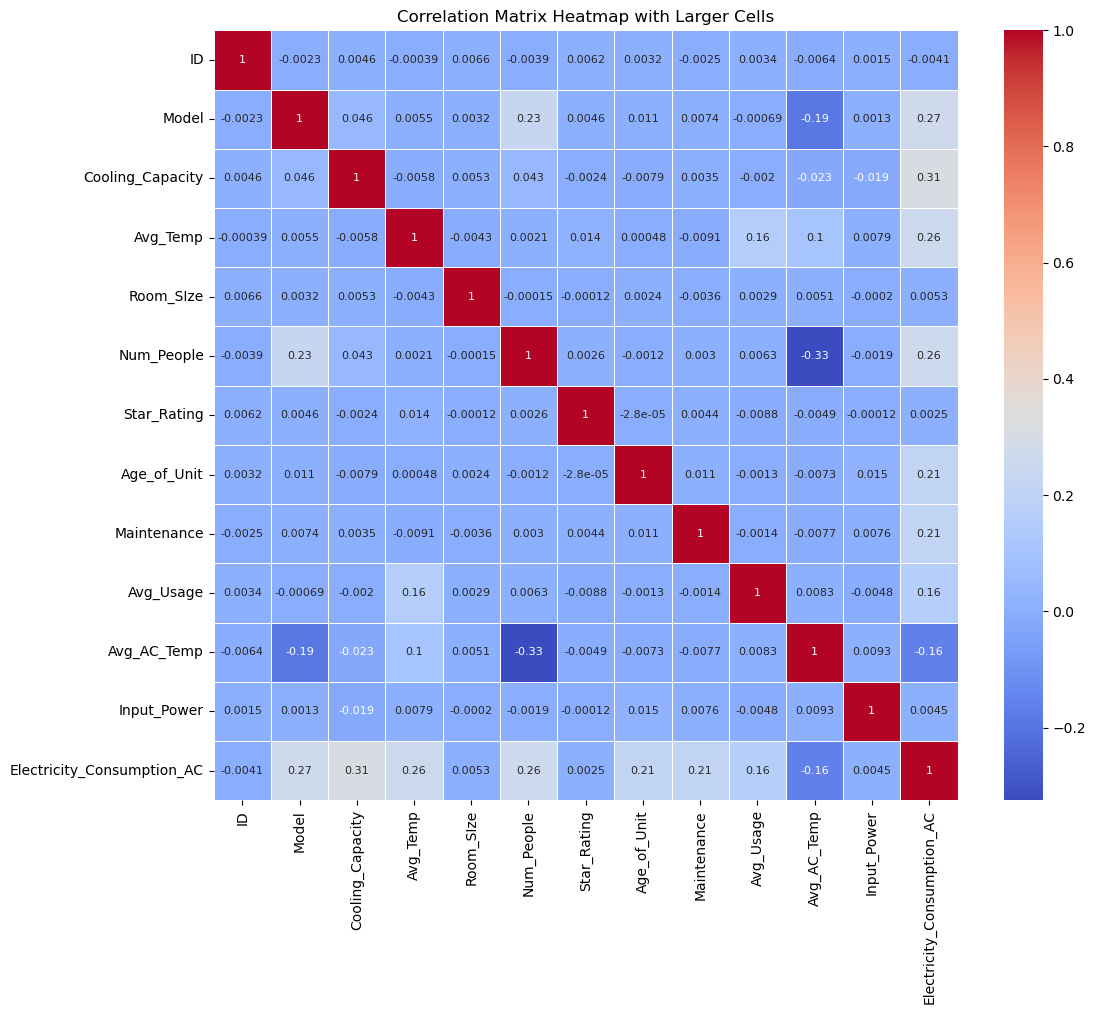

In [20]:
# Increase the cell size by adjusting the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap with larger cells
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})

plt.title('Correlation Matrix Heatmap with Larger Cells')
plt.show()


# 3. Feature Engineering

#### Seperating feture and label

In [21]:
X_data = data.drop(['Electricity_Consumption_AC','ID'],axis=1)
y = data['Electricity_Consumption_AC']

test_data = test.copy()
test_data = test.drop('ID',axis=1)

### 1.Label Encoding

In [22]:
# Grouping categorical Features in Train Data
Train_DF_cat = X_data.select_dtypes(exclude=['int64', 'float64', 'int32'])
Train_DF_num = X_data.select_dtypes(include=['int64', 'float64', 'int32'])
Train_DF_cat.head(1)

# Grouping categorical Features in Train Data
Test_DF_cat = test_data.select_dtypes(exclude=['int64', 'float64', 'int32'])
Test_DF_num = test_data.select_dtypes(include=['int64', 'float64', 'int32'])
Test_DF_cat.head(1)

,Type_of_AC,City
0,Portable,Moscow


In [23]:
Train_DF_cat.head(1)

,Type_of_AC,City
0,Split,Cairo


In [24]:
combined_data_type= pd.concat([Train_DF_cat['Type_of_AC'], Test_DF_cat['Type_of_AC']], axis=0)
combined_data_city= pd.concat([Train_DF_cat['City'], Test_DF_cat['City']], axis=0)

In [25]:
# Initialize and fit the label encoder on combined data
label_encoder = LabelEncoder()
combined_data_type=label_encoder.fit(combined_data_type)
Train_DF_cat['Type_of_AC'] = combined_data_type.transform(Train_DF_cat['Type_of_AC'])
Test_DF_cat['Type_of_AC'] =  combined_data_type.transform(Test_DF_cat['Type_of_AC'])

combined_data_city=label_encoder.fit(combined_data_city)
Train_DF_cat['City'] = combined_data_city.transform(Train_DF_cat['City'])
Test_DF_cat['City'] = combined_data_city.transform(Test_DF_cat['City'])

In [26]:
# Concatanating the Train catagorical data and numberical data after encoding catagorical features.
Train_Data_encoded = pd.concat([Train_DF_cat, Train_DF_num], axis=1)
Test_Data_encoded = pd.concat([Test_DF_cat, Test_DF_num], axis=1)
Train_Data_encoded.head(1)

,Type_of_AC,City,Model,Cooling_Capacity,Avg_Temp,Room_SIze,Num_People,Star_Rating,Age_of_Unit,Maintenance,Avg_Usage,Avg_AC_Temp,Input_Power
0,2,2,1.5,6579.15,43,1873.5,3,3.0,5.0,0,1.72,31.333333,2863.295221


In [27]:
#printing the shape of bith the data train and test
print("shape of train data :",Train_Data_encoded.shape,'\n')
print("shape of test data :",Test_Data_encoded.shape)

shape of train data : (15000, 13) 

shape of test data : (5000, 13)


### 2.Feature Scaling

In [28]:
# Scaling Train and Test Data
Train_DF_scaled = Train_Data_encoded
Test_DF_scaled = Test_Data_encoded

# Standardization of Train and Test Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Train_DF_scaled)
Train_DF_scaled = pd.DataFrame(scaled_data, columns=Train_DF_scaled.columns)

#scaler = StandardScaler()
scaled_test_data = scaler.transform(Test_DF_scaled)
Test_DF_scaled = pd.DataFrame(scaled_test_data, columns=Test_DF_scaled.columns)

In [29]:
#printing the shape of bith the data train and test
print("shape of train data after standerdization :",Train_DF_scaled.shape,'\n')
print("shape of test data after standerdization :",Test_DF_scaled.shape)

shape of train data after standerdization : (15000, 13) 

shape of test data after standerdization : (5000, 13)


### Splitting the train data into train and test accuracy

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Train_DF_scaled,y,test_size=0.20,random_state=42)

In [31]:
print('x_train shape :',X_train.shape,'\n')
print('y_train shape :',y_train.shape,'\n')
print('X_test shape :',X_test.shape,'\n')
print('y_test shape :',y_test.shape,'\n')

x_train shape : (12000, 13) 

y_train shape : (12000,) 

X_test shape : (3000, 13) 

y_test shape : (3000,) 



In [32]:
X_train

,Type_of_AC,City,Model,Cooling_Capacity,Avg_Temp,Room_SIze,Num_People,Star_Rating,Age_of_Unit,Maintenance,Avg_Usage,Avg_AC_Temp,Input_Power
9839,-0.440323,-1.003434,-0.614265,-0.955589,-1.090651,0.014135,-0.698267,0.008165,-1.544559,-0.540052,-0.041358,-0.199361,0.014143
9680,1.347427,-1.003434,-1.003602,-0.807079,-1.490060,0.014129,-0.698267,0.008165,1.551508,-0.540052,-0.294324,1.016469,0.014143
7093,-0.440323,0.210319,3.779674,0.021889,-1.290356,0.014143,0.552652,0.008165,0.003474,-0.540052,-0.428876,-0.661010,0.014144
11293,0.453552,-0.275182,-0.447407,0.037191,-1.290356,0.014138,-0.760813,0.008165,0.003474,-0.540052,1.237547,-0.862125,0.014144
820,1.347427,-1.246185,-0.058070,-0.003803,-0.092130,0.014149,0.552652,0.008165,0.003474,-0.540052,1.167737,-1.374053,0.014144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0.453552,-1.003434,-0.336168,-0.239893,0.307278,0.014142,-0.823359,0.008165,-1.544559,1.851674,1.116694,1.453741,0.014143
13418,-0.440323,-0.275182,0.386885,-0.335318,3.103138,0.014156,1.365749,0.008165,-1.028548,-0.540052,-1.979701,0.157272,0.014144
5390,0.453552,1.181322,-0.836743,-0.611891,-0.890947,0.014133,-1.010997,0.008165,-1.544559,1.851674,-0.268990,1.027134,0.014142
860,-0.440323,-1.246185,0.108788,0.066548,1.505504,0.014150,0.615198,0.008165,1.551508,-0.540052,1.245804,-0.290934,0.014145


### Model Building

In [33]:
# Initialize and train regression models
svm_reg = SVR(kernel='linear')
random_forest_reg = RandomForestRegressor()
linear_reg = LinearRegression()
xgb_reg = XGBRegressor()

svm_reg.fit(X_train, y_train)
random_forest_reg.fit(X_train, y_train)
linear_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
# Make predictions on the test data
svm_preds = svm_reg.predict(X_test)
random_forest_preds = random_forest_reg.predict(X_test)
linear_reg_preds = linear_reg.predict(X_test)
xgb_preds = xgb_reg.predict(X_test)

# Evaluate the performance of each model
svm_mse = mean_squared_error(y_test, svm_preds)
random_forest_mse = mean_squared_error(y_test, random_forest_preds)
linear_reg_mse = mean_squared_error(y_test, linear_reg_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)

svm_r2 = r2_score(y_test, svm_preds)
random_forest_r2 = r2_score(y_test, random_forest_preds)
linear_reg_r2 = r2_score(y_test, linear_reg_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

In [35]:
# Print the evaluation metrics
print("SVM Regression MSE:", svm_mse)
print("Random Forest Regression MSE:", random_forest_mse)
print("Linear Regression MSE:", linear_reg_mse)
print("XGBoost Regression MSE:", xgb_mse,'\n\n')

print("SVM Regression R-squared:", svm_r2)
print("Random Forest Regression R-squared:", random_forest_r2)
print("Linear Regression R-squared:", linear_reg_r2)
print("XGBoost Regression R-squared:", xgb_r2)

SVM Regression MSE: 0.08959169161266374
Random Forest Regression MSE: 0.04843052517399998
Linear Regression MSE: 0.0891492191579393
XGBoost Regression MSE: 0.04087828477374854 


SVM Regression R-squared: 0.3832265475387211
Random Forest Regression R-squared: 0.6665911573003646
Linear Regression R-squared: 0.38627264766929204
XGBoost Regression R-squared: 0.7185828241796874


## Hyper Paramter Tunning

In [36]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize the XGBoost Regressor
xgb_reg = XGBRegressor()

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_xgb_reg = XGBRegressor(**best_params)
best_xgb_reg.fit(X_train, y_train)

# Make predictions on the test data
xgb_preds = best_xgb_reg.predict(X_test)

# Calculate the Mean Squared Error (MSE) for the tuned model
mse = mean_squared_error(y_test, xgb_preds)

print("Best Hyperparameters:", best_params)
print("Tuned XGBoost Model MSE:", mse)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Tuned XGBoost Model MSE: 0.03407374935838478


### Model Building using Best Paramters

In [41]:
from xgboost import XGBRegressor

# Define the hyperparameters
xgb_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

# Initialize the XGBoost Regressor with the specified hyperparameters
xgb_reg = XGBRegressor(**xgb_params)

# Train the model on your training data (X_train, y_train)
xgb_reg.fit(X_train, y_train)

# Make predictions on your test data (X_test)
xgb_preds = xgb_reg.predict(X_test)

In [42]:
xgb_preds

array([1.7605911, 2.6775608, 2.0503561, ..., 2.3688328, 1.9928875,
       1.9997829], dtype=float32)

In [43]:
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

In [44]:
print("XGBoost Regression MSE:", xgb_mse,'\n\n')
print("XGBoost Regression R-squared:", xgb_r2)

XGBoost Regression MSE: 0.03407374935838478 


XGBoost Regression R-squared: 0.7654270875816269


### Predictions for Test

In [47]:
test.head(1)

,ID,Type_of_AC,Model,Cooling_Capacity,Avg_Temp,Room_SIze,Num_People,Star_Rating,Age_of_Unit,Maintenance,Avg_Usage,Avg_AC_Temp,City,Input_Power
0,191220,Portable,2.1,4283.4,35,NaN,9,NaN,5.0,0,8.77,14.888889,Moscow,2906.044714


In [48]:
Test_DF_scaled.head(1)

,Type_of_AC,City,Model,Cooling_Capacity,Avg_Temp,Room_SIze,Num_People,Star_Rating,Age_of_Unit,Maintenance,Avg_Usage,Avg_AC_Temp,Input_Power
0,-0.440323,0.210319,-0.391787,-0.211148,-0.291834,NaN,-0.635721,NaN,1.035497,-0.540052,-0.460778,-0.707734,0.014143


In [49]:
# Make predictions on your test data  (test)
xgb_preds_test = xgb_reg.predict(Test_DF_scaled)

In [50]:
test['Electricity_Consumption_AC'] = xgb_preds_test
Final_Result = test[['ID','Electricity_Consumption_AC']] 

In [53]:
Final_Result.to_csv('submission.csv',index=False)

---------------------------------------------Thank you----------------------------------------